# ENSE 885AY Assignment 5: Face Detection with a Sliding Window
1. Extract features for positive examples
2. Extract features for random negative examples
3. Mine hard negatives
4. Train a linear classifier
5. Detect faces on the test set

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from utils_exp import *
import student_code_exp as sc

In [2]:
data_path = osp.join('..','data')
# Positive training examples. 36x36 head crops
train_path_pos = osp.join(data_path, 'caltech_faces', 'Caltech_CropFaces')
# Mine random or hard negatives from here
non_face_scn_path = osp.join(data_path, 'train_non_face_scenes')
# CMU+MIT test scenes
test_scn_path = osp.join(data_path, 'test_scenes', 'test_jpg')
# Ground truth face locations in the test set
label_filename = osp.join(data_path, 'test_scenes', 'ground_truth_bboxes.txt')

# The faces are 36x36 pixels, which works fine as a template size. You could
# add other fields to this dict if you want to modify HoG default
# parameters such as the number of orientations, but that does not help
# performance in our limited test.
feature_params = {'template_size': 36, 'hog_cell_size': 6}

# Number of negatives to use for training.
# Higher will work strictly better, but you should start with 10000 for debugging
num_negative_examples = 10000

## Section 1: Load positive training crops and random negative examples

In [3]:
import student_code_exp as sc

features_pos, features_pos_multi = sc.get_positive_features(train_path_pos, feature_params)

******* get_positive_features info *******


Extracted feats from normal image feats.shape:  (6713, 1116)


Extracted feats from flipped image feats_flip.shape:  (6713, 1116)


Extracted feats from warped image feats_warp.shape:  (20139, 1116)


In [4]:
import student_code_exp as sc

features_neg, features_neg_multi = sc.get_random_negative_features(non_face_scn_path, feature_params,
                                               num_negative_examples)

******* get_random_negative_features info *******


Extracted feats from normal image feats.shape:  (10000, 1116)


Extracted feats from multi-scale image feats_multi_scale.shape:  (10000, 1116)


## Experiment A

In [5]:
# exp A
import student_code_exp as sc

data_pos = [features_pos, features_pos_multi]
data_neg = [features_neg, features_neg_multi]

# Initial matrices
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]

N_svm = len(data_pos)*len(svm_lambda)

data_neg2 = list(np.arange(N_svm))

svm_1a = list(np.arange(N_svm))
svm_2a = list(np.arange(N_svm))


ap_svm1a = np.zeros((2, N_svm))
ap_svm2a = np.zeros((2, N_svm))

detections_1a_sin = list(np.arange(N_svm))
detections_1a_mul = list(np.arange(N_svm))
detections_2a_sin = list(np.arange(N_svm))
detections_2a_mul = list(np.arange(N_svm))

# SVM on bags_of_sifts
for data_idx in range(len(data_pos)):
    features_pos_ = data_pos[data_idx]
    features_neg_ = data_neg[data_idx]
    # features_neg2_ = data_neg2[data_idx]

    for lam_idx, C in enumerate(svm_lambda):
        k_svm = data_idx*len(svm_lambda)+lam_idx
        # Section 2: Train Classifier
        svm1 = sc.train_classifier(features_pos_, features_neg_, C)
        
        if data_idx == 0:
            #  Section 4: Mine Hard Negatives
            hard_negs, hard_negs_multi = sc.mine_hard_negs(non_face_scn_path, svm1, feature_params)

            features_neg_2 = np.vstack((data_neg[0], hard_negs))

            features_neg_multi_2 = np.vstack((data_neg[1], hard_negs_multi))

            data_neg2[0*len(svm_lambda)+lam_idx] = features_neg_2
            data_neg2[1*len(svm_lambda)+lam_idx] = features_neg_multi_2


        # features_neg_2
        features_neg2_ = data_neg2[k_svm]
        
        svm2 = sc.train_classifier(features_pos_, features_neg2_, C)
        
        svm_1a[k_svm] = svm1
        svm_2a[k_svm] = svm2

        for scale_id in range(2):
            print('\ndata_idx: ', data_idx, 'lam_idx: ', lam_idx, 'scale_id: ', scale_id, 'k_svm: ', k_svm)
            # Section 5: Run Detector on Test Set
            bboxes, confidences, image_ids = sc.run_detector(test_scn_path, svm1, feature_params, scale_id=scale_id)
            bboxes2, confidences2, image_ids2 = sc.run_detector(test_scn_path, svm2, feature_params, scale_id=scale_id)

            # evaluate
            gt_ids, gt_bboxes, gt_isclaimed, tp, fp, duplicate_detections, ap = \
                evaluate_detections(bboxes, confidences, image_ids, label_filename, False)
            
            gt_ids2, gt_bboxes2, gt_isclaimed2, tp2, fp2, duplicate_detections2, ap2 = \
                evaluate_detections(bboxes2, confidences2, image_ids2, label_filename, False)
            # save ap
            ap_svm1a[scale_id, k_svm] = ap
            ap_svm2a[scale_id, k_svm] = ap2
            
            
            dets = [bboxes, confidences, image_ids]
            dets2 = [bboxes2, confidences2, image_ids2]
            
            if scale_id == 0:
                detections_1a_sin[k_svm] = dets
                detections_2a_sin[k_svm] = dets2
            else:
                detections_1a_mul[k_svm] = dets
                detections_2a_mul[k_svm] = dets2



data_idx:  0 lam_idx:  0 scale_id:  0 k_svm:  0
ap:  0.213884044346304
ap:  0.22084569862410683

data_idx:  0 lam_idx:  0 scale_id:  1 k_svm:  0
ap:  0.5995462079811273
ap:  0.6075289277290973

data_idx:  0 lam_idx:  1 scale_id:  0 k_svm:  1
ap:  0.30731072577833995
ap:  0.31343131110345496

data_idx:  0 lam_idx:  1 scale_id:  1 k_svm:  1
ap:  0.7125530789721078
ap:  0.7184772819848729

data_idx:  0 lam_idx:  2 scale_id:  0 k_svm:  2
ap:  0.3563806886567419
ap:  0.36376537326102865

data_idx:  0 lam_idx:  2 scale_id:  1 k_svm:  2
ap:  0.7688473872626036
ap:  0.7794991934127141

data_idx:  0 lam_idx:  3 scale_id:  0 k_svm:  3
ap:  0.35633046071756314
ap:  0.3606611351735279

data_idx:  0 lam_idx:  3 scale_id:  1 k_svm:  3
ap:  0.7717166891400559
ap:  0.7874429264804363

data_idx:  0 lam_idx:  4 scale_id:  0 k_svm:  4
ap:  0.35446132748238823
ap:  0.36408191552948604

data_idx:  0 lam_idx:  4 scale_id:  1 k_svm:  4
ap:  0.7756644621897875
ap:  0.7850023393448953

data_idx:  0 lam_idx:  

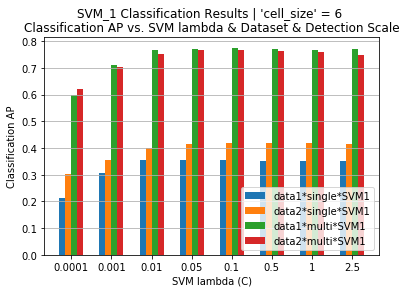

In [15]:
# Plot SVM Classification Results
# svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]
nC = len(svm_lambda)
x = 2*np.arange(len(svm_lambda))
wid = 0.3

plt.figure()
k = 0; plt.bar(x-2*wid, ap_svm1a[0,:nC], width=wid, align='edge', label='data1*single*SVM1')
k = k+1; plt.bar(x-wid, ap_svm1a[0,nC:], width=wid, align='edge', label='data2*single*SVM1')
k = k+1; plt.bar(x, ap_svm1a[1,:nC], width=wid, align='edge', label='data1*multi*SVM1')
k = k+1; plt.bar(x+wid, ap_svm1a[1,nC:], width=wid, align='edge', label='data2*multi*SVM1')


plt.grid(b=None, which='major', axis='y')
plt.title("SVM_1 Classification Results | 'cell_size' = 6 \nClassification AP vs. SVM lambda & Dataset & Detection Scale")
plt.xlabel("SVM lambda (C)")
plt.ylabel("Classification AP")
plt.xticks(x, svm_lambda)#, rotation=20)
plt.legend(loc='lower right')
plt.savefig("SVM1_a.png", bbox_inches = "tight", dpi=300)
plt.show()

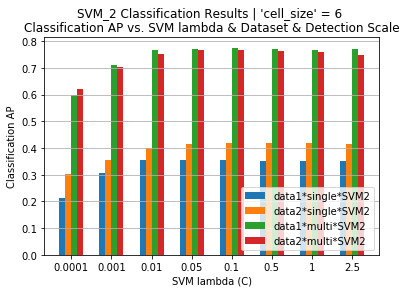

In [16]:
# Plot SVM Classification Results
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]
nC = len(svm_lambda)
x = 2*np.arange(len(svm_lambda))
wid = 0.3

# ap_svm1[scale_id, data_idx*len(svm_lambda)+lam_idx] = ap
plt.figure()
k = 0; plt.bar(x-2*wid, ap_svm1a[0,:nC], width=wid, align='edge', label='data1*single*SVM2')
k = k+1; plt.bar(x-wid, ap_svm1a[0,nC:], width=wid, align='edge', label='data2*single*SVM2')
k = k+1; plt.bar(x, ap_svm1a[1,:nC], width=wid, align='edge', label='data1*multi*SVM2')
k = k+1; plt.bar(x+wid, ap_svm1a[1,nC:], width=wid, align='edge', label='data2*multi*SVM2')


plt.grid(b=None, which='major', axis='y')
plt.title("SVM_2 Classification Results | 'cell_size' = 6 \nClassification AP vs. SVM lambda & Dataset & Detection Scale")
plt.xlabel("SVM lambda (C)")
plt.ylabel("Classification AP")
plt.xticks(x, svm_lambda)#, rotation=20)
plt.legend(loc='lower right')
plt.savefig("SVM2_a.png", bbox_inches = "tight", dpi=300)
plt.show()

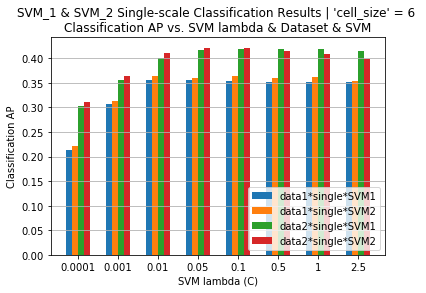

In [17]:
# Plot SVM Classification Results
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]
nC = len(svm_lambda)
x = 2*np.arange(len(svm_lambda))
wid = 0.3

# ap_svm1[scale_id, data_idx*len(svm_lambda)+lam_idx] = ap
plt.figure()
k = 0; plt.bar(x-2*wid, ap_svm1a[0,:nC], width=wid, align='edge', label='data1*single*SVM1')
k = k+1; plt.bar(x-wid, ap_svm2a[0,:nC], width=wid, align='edge', label='data1*single*SVM2')
k = k+1; plt.bar(x, ap_svm1a[0,nC:], width=wid, align='edge', label='data2*single*SVM1')
k = k+1; plt.bar(x+wid, ap_svm2a[0,nC:], width=wid, align='edge', label='data2*single*SVM2')


plt.grid(b=None, which='major', axis='y')
plt.title("SVM_1 & SVM_2 Single-scale Classification Results | 'cell_size' = 6 \nClassification AP vs. SVM lambda & Dataset & SVM")
plt.xlabel("SVM lambda (C)")
plt.ylabel("Classification AP")
plt.xticks(x, svm_lambda)#, rotation=20)
plt.legend(loc='lower right')
plt.savefig("SVM1and2_sin_a.png", bbox_inches = "tight", dpi=300)
plt.show()

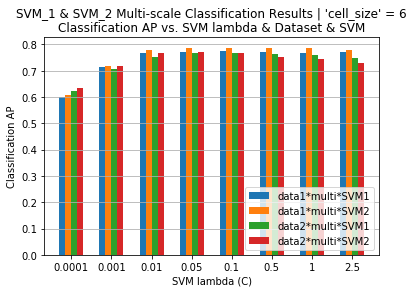

In [18]:
# Plot SVM Classification Results
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]
nC = len(svm_lambda)
x = 2*np.arange(len(svm_lambda))
wid = 0.3

# ap_svm1[scale_id, data_idx*len(svm_lambda)+lam_idx] = ap
plt.figure()
k = 0; plt.bar(x-2*wid, ap_svm1a[1,:nC], width=wid, align='edge', label='data1*multi*SVM1')
k = k+1; plt.bar(x-wid, ap_svm2a[1,:nC], width=wid, align='edge', label='data1*multi*SVM2')
k = k+1; plt.bar(x, ap_svm1a[1,nC:], width=wid, align='edge', label='data2*multi*SVM1')
k = k+1; plt.bar(x+wid, ap_svm2a[1,nC:], width=wid, align='edge', label='data2*multi*SVM2')


plt.grid(b=None, which='major', axis='y')
plt.title("SVM_1 & SVM_2 Multi-scale Classification Results | 'cell_size' = 6\nClassification AP vs. SVM lambda & Dataset & SVM")
plt.xlabel("SVM lambda (C)")
plt.ylabel("Classification AP")
plt.xticks(x, svm_lambda)#, rotation=20)
plt.legend(loc='lower right')
plt.savefig("SVM1and2_mul_a.png", bbox_inches = "tight", dpi=300)
plt.show()


data_idx:  0 lam_idx:  0
Accuracy = 98.211%
True Positive rate = 96.157%
False Positive rate = 0.410%
True Negative rate = 99.590%
False Negative rate = 3.843%

data_idx:  0 lam_idx:  2
Accuracy = 99.659%
True Positive rate = 99.359%
False Positive rate = 0.140%
True Negative rate = 99.860%
False Negative rate = 0.641%

data_idx:  0 lam_idx:  4
Accuracy = 99.940%
True Positive rate = 99.881%
False Positive rate = 0.020%
True Negative rate = 99.980%
False Negative rate = 0.119%

data_idx:  0 lam_idx:  6
Accuracy = 100.000%
True Positive rate = 100.000%
False Positive rate = 0.000%
True Negative rate = 100.000%
False Negative rate = 0.000%


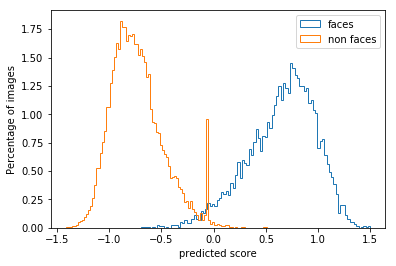

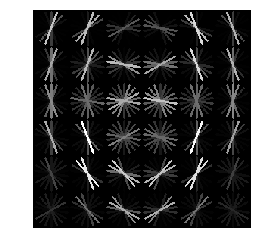

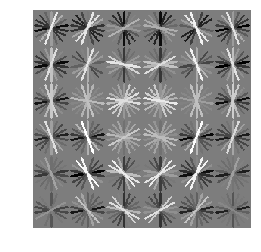

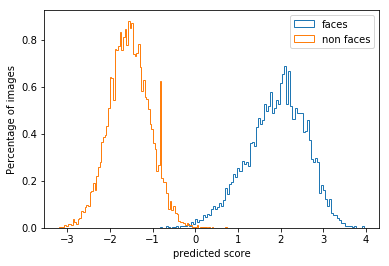

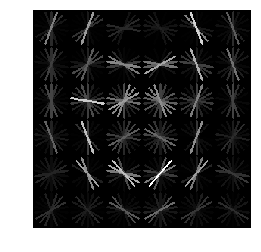

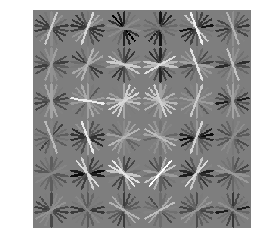

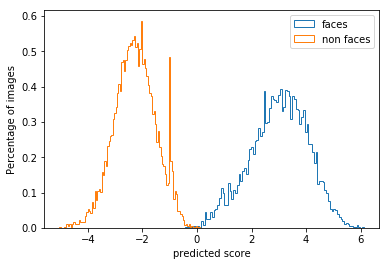

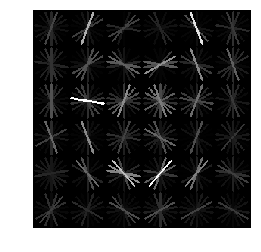

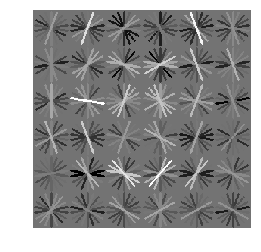

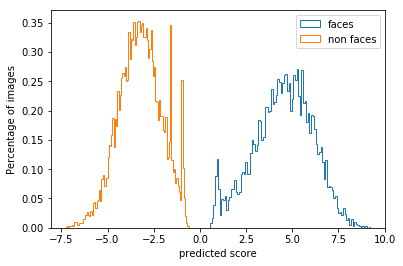

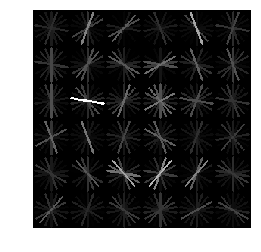

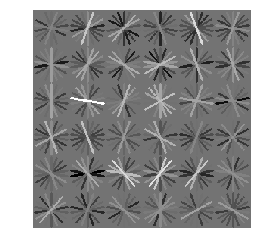

In [13]:
# HOG vis

# Initial matrices
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]

# SVM on bags_of_sifts
for data_idx in [0]: #range(len(data_pos)):
    features_pos_ = data_pos[data_idx]
    features_neg_ = data_neg[data_idx]
    features_neg2_ = data_neg2[data_idx]

    for lam_idx, C in enumerate(svm_lambda):
        
        if lam_idx % 2 == 0:
            print('\ndata_idx: ', data_idx, 'lam_idx: ', lam_idx)

            svm = svm_1a[data_idx*len(svm_lambda)+lam_idx]
            # svm2 = svm_2a[data_idx*len(svm_lambda)+lam_idx]

            # 
            confidences = svm.decision_function(np.vstack((features_pos_, features_neg_)))
            label_vector = np.hstack((np.ones(len(features_pos_)), -np.ones(len(features_neg_))))
            [tp_rate, fp_rate, tn_rate, fn_rate] = report_accuracy(confidences, label_vector)

            # 
            face_confs = confidences[label_vector > 0]
            non_face_confs = confidences[label_vector < 0]
            plt.figure()
            plt.hist(np.sort(face_confs), 100, facecolor='g', histtype='step', density=1,label='faces')
            plt.hist(np.sort(non_face_confs), 100, facecolor='r', histtype='step',density=1, label='non faces')
            # plt.plot([0, len(non_face_confs)], [0, 0], 'b', label='decision boundary')
            plt.xlabel('predicted score')
            plt.ylabel('Percentage of images')
            plt.legend()

            # 
            visualize_hog(svm, feature_params)


data_idx:  1 lam_idx:  0
Accuracy = 98.712%
True Positive rate = 99.455%
False Positive rate = 3.780%
True Negative rate = 96.220%
False Negative rate = 0.545%

data_idx:  1 lam_idx:  2
Accuracy = 99.550%
True Positive rate = 99.657%
False Positive rate = 0.810%
True Negative rate = 99.190%
False Negative rate = 0.343%

data_idx:  1 lam_idx:  4
Accuracy = 99.777%
True Positive rate = 99.833%
False Positive rate = 0.410%
True Negative rate = 99.590%
False Negative rate = 0.167%

data_idx:  1 lam_idx:  6
Accuracy = 99.970%
True Positive rate = 99.982%
False Positive rate = 0.070%
True Negative rate = 99.930%
False Negative rate = 0.018%


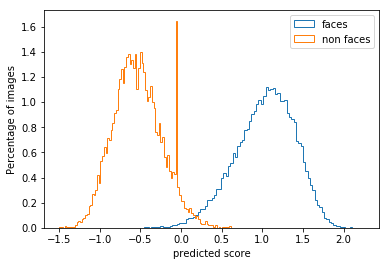

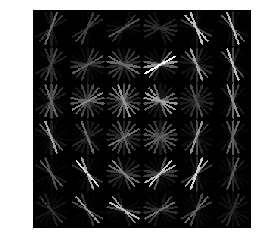

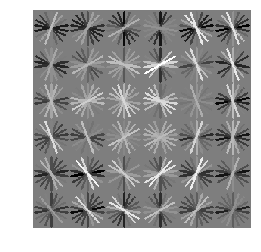

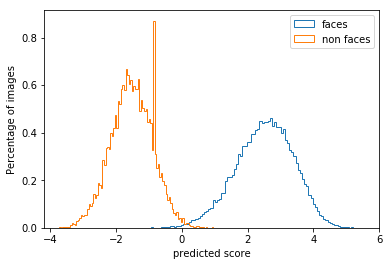

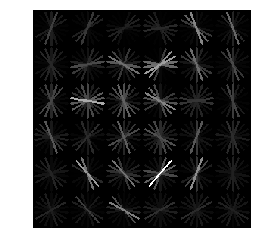

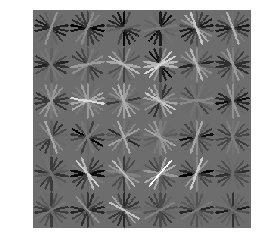

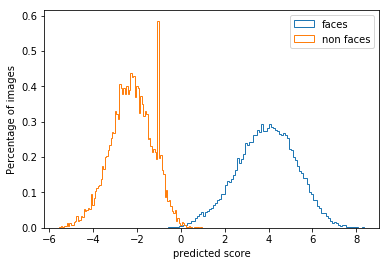

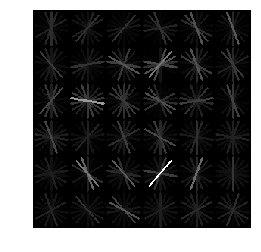

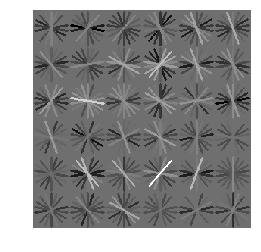

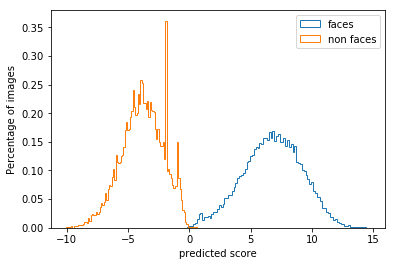

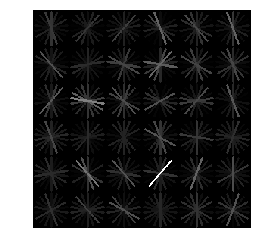

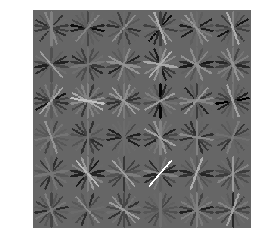

In [14]:
# HOG vis

# Initial matrices
svm_lambda = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2.5]

# SVM on bags_of_sifts
for data_idx in [1]: #range(len(data_pos)):
    features_pos_ = data_pos[data_idx]
    features_neg_ = data_neg[data_idx]
    features_neg2_ = data_neg2[data_idx]

    for lam_idx, C in enumerate(svm_lambda):
        
        if lam_idx % 2 == 0:
            print('\ndata_idx: ', data_idx, 'lam_idx: ', lam_idx)

            svm = svm_1a[data_idx*len(svm_lambda)+lam_idx]
            # svm2 = svm_2a[data_idx*len(svm_lambda)+lam_idx]

            # 
            confidences = svm.decision_function(np.vstack((features_pos_, features_neg_)))
            label_vector = np.hstack((np.ones(len(features_pos_)), -np.ones(len(features_neg_))))
            [tp_rate, fp_rate, tn_rate, fn_rate] = report_accuracy(confidences, label_vector)

            # 
            face_confs = confidences[label_vector > 0]
            non_face_confs = confidences[label_vector < 0]
            plt.figure()
            plt.hist(np.sort(face_confs), 100, facecolor='g', histtype='step', density=1,label='faces')
            plt.hist(np.sort(non_face_confs), 100, facecolor='r', histtype='step',density=1, label='non faces')
            # plt.plot([0, len(non_face_confs)], [0, 0], 'b', label='decision boundary')
            plt.xlabel('predicted score')
            plt.ylabel('Percentage of images')
            plt.legend()

            # 
            visualize_hog(svm, feature_params)